In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from typing import Callable

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
df_test = pd.read_csv('../data/raw/triathlon_watch_test_data_final.csv')
df_training = pd.read_csv('../data/raw/triathlon_watch_training_data_final.csv')

In [3]:
df_training.dropna(subset=['User of latest model'], inplace=True)
df_training.drop_duplicates(subset='ID', inplace=True)
df_training.set_index("ID", inplace=True)

In [4]:
df_training['Most current software update'] = pd.to_datetime(df_training['Most current software update'])
df_training['Days since Update'] = (pd.Timestamp.today() - df_training['Most current software update']).dt.days
df_training.drop(columns=['Most current software update'], inplace=True)

def fill_days_since_update(df):
    """
    Füllt fehlende Werte in 'Days since Update' mit dem Mittelwert je Label.
    """
    df['Days since Update'] = df.groupby('User of latest model')['Days since Update'].transform(lambda x: x.fillna(x.mean()))
    return df
df_training = fill_days_since_update(df_training)


In [5]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 971 entries, C0001 to C1000
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age of customer                971 non-null    float64
 1   Sex                            971 non-null    object 
 2   Ctry                           971 non-null    object 
 3   Town                           932 non-null    object 
 4   Swimming Hours per Week        971 non-null    float64
 5   Biking Hours per Week          947 non-null    float64
 6   Running Hours per Week         971 non-null    float64
 7   Total Training Hours per Week  971 non-null    float64
 8   VO2 Max                        967 non-null    float64
 9   10k Running Time Prediction    971 non-null    float64
 10  Calories Burned per Week       952 non-null    float64
 11  Support Cases of Customer      971 non-null    float64
 12  Customer Years                 971 non-null    fl

In [6]:
df_training.shape

(971, 20)

In [7]:
###############
# Split für alle Pipelines die gebaut und ergänzt werden
###############
X = df_training.drop('User of latest model', axis=1)
y = df_training['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [8]:
def create_pipeline(custom_transform_steps : Callable[[pd.DataFrame], pd.DataFrame]) -> Pipeline:
    """
    Erstellt eine Machine-Learning-Pipeline zur Datenvorverarbeitung und Modellierung.

    Diese Pipeline umfasst:
    - Benutzerdefinierte Transformationen (definiert durch `custom_transform_steps`).
    - Vorverarbeitung numerischer und kategorialer Merkmale.
    - Modelltraining mit logistischer Regression.

    Args:
    custom_transform_steps (function): 
        Eine Funktion, die benutzerdefinierte Transformationen auf den DataFrame anwendet. 
        Diese Funktion sollte einen DataFrame als Eingabe erhalten und einen transformierten DataFrame zurückgeben.

    Returns:
    sklearn.pipeline.Pipeline:
        Eine vollständige Pipeline, die Vorverarbeitung, benutzerdefinierte Transformationen und Modelltraining kombiniert.
    """
    # Definiere die Spalten für numerische und kategorische Features
    numeric_features = ['Age of customer', 'Swimming Hours per Week', 'Biking Hours per Week', 'Running Hours per Week', 'Total Training Hours per Week', 'VO2 Max', "10k Running Time Prediction", 'Calories Burned per Week', 'Support Cases of Customer', 'Customer Years', "Days since Update"]
    categorical_features = ['Sex', 'Ctry', 'Town', "Preferred Training Daytime", 'Subscription Type',  "Goal of Training", 'Synchronisation'] #"Most current software update",
    #Color of Watch (und Preferred Training Daytime) wurden entfernt, da im Laufe der Eda als irrelevant identifiziert

    # Transformationen für numerische Features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=None))  # Fehlende Werte durch Median ersetzen; fill_value=None, da imputing von fehlenden Werten nicht notwendig um den Effekt von Age zb zu sehen 
    ])              #SimpleImputer(strategy='median')

    # Transformationen für kategorische Features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fehlende Werte durch 'missing' ersetzen
        ('onehot', OneHotEncoder(handle_unknown='ignore', categories='auto'))  # One-Hot-Encoding
    ])

    # Kombination der Transformationen in einem ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Gesamte Pipeline mit Funktionen für Transformationen custom_transform_steps
    pipeline = Pipeline(steps=[
        ('custom_transform', FunctionTransformer(custom_transform_steps)),  # Benutzerdefinierte Transformationen
        ('preprocessor', preprocessor),  # Vorverarbeitung (Imputation, Encoding)
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Logistische Regression
    ])

    return pipeline

**Pipeline**\
Die Pipeline-Architektur folgt einem modularen Ansatz zur automatisierten Datenverarbeitung und Modellierung. Sie besteht aus drei Hauptkomponenten:

1. Benutzerdefinierte Transformationen (`custom_transform_steps`):
2. Feature-Vorverarbeitung (`preprocessor`):
3. Modell (`classifier`):

Diese Pipeline wird im gesamten Notebook genutzt, um eine konsistente und wiederholbare Verarbeitung sicherzustellen. Alle Daten durchlaufen dieselben Schritte, was die Reproduzierbarkeit der Ergebnisse gewährleistet.

Die Feature habe ich mal so gelassen, da die tatsächliche Feature Selection nach Miro im letzen Schritt drankommt.

Weitere Infos zu dieser Pipeline beim Baseline Modell.

# Baseline Model Logistic Regression

In [9]:
# daten verändern bis zelle 621 in eda.py für baseline model

In [10]:
# Funktionen für Transformationen
def replace_germayn(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt falsche Schreibweise von 'Germany' in der Spalte 'Ctry'.
    
    Args:
    df (pd.DataFrame): Eingabedaten
    
    Return:
    pd.DataFrame: Bereinigte Daten mit korrigiertem Ländernamen
    """
    df['Ctry'] = df['Ctry'].replace('Germayn', 'Germany')
    return df

def replace_unknownland(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt 'UnknownLand' in der Spalte 'Ctry' durch NaN, um als fehlender Wert behandelt zu werden.
    
    Args:
    df (pd.DataFrame): Eingabedaten
    
    Return:
    pd.DataFrame: Daten mit ersetzten Werten für 'UnknownLand'
    """
    df['Ctry'] = df['Ctry'].replace('UnknownLand', np.nan)
    return df

def replace_negative_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt negative Alterswerte (-1) in der Spalte 'Age of customer' durch NaN.
    
    Args:
    df (pd.DataFrame): Eingabedaten
    
    Return:
    pd.DataFrame: Daten mit korrigierten Alterswerten
    """
    df['Age of customer'] = df['Age of customer'].replace(-1, np.nan)
    return df

def custom_transform_baseline(df: pd.DataFrame) -> pd.DataFrame:
    """
    Führt alle benutzerdefinierten Transformationen auf den Daten durch:
    - Ersetzt 'Germayn' durch 'Germany'
    - Setzt 'UnknownLand' auf NaN
    - Ersetzt negative Alterswerte durch NaN
    
    Args:
    df (pd.DataFrame): Eingabedaten
    
    Return:
    pd.DataFrame: Bereinigte Daten nach Anwendung aller Transformationen
    """
    df = df.copy()
    df = replace_germayn(df)
    df = replace_unknownland(df)
    #df = replace_negative_age(df)
    for col in ['Ctry', 'Town', 'Subscription Type', 'Synchronisation']:  
        df[col] = df[col].astype(str)
    return df

In [11]:
pipeline_baseline = create_pipeline(custom_transform_baseline)

# Trainiere das Modell
pipeline_baseline.fit(X_train, y_train)

y_pred_baseline = pipeline_baseline.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_baseline))
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))

Accuracy: 0.7692307692307693
Confusion Matrix:
 [[94 16]
 [29 56]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.85      0.81       110
         1.0       0.78      0.66      0.71        85

    accuracy                           0.77       195
   macro avg       0.77      0.76      0.76       195
weighted avg       0.77      0.77      0.77       195



/Applications/anaconda3/envs/intro_ds_ai/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
X_train_transformed = pipeline_baseline[:-2].transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed)
X_train_transformed_df

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Color of Watch,Synchronisation,Days since Update
ID,,,,,,,,,,,,,,,,,,,
C0892,43.0,Male,Germany,Berlin,3.26,6.05,0.36,9.68,50.14,43.60,4712.94,1.0,2.0,Fitness,Morning,Free,Black,Yes,455.0
C0201,25.0,Male,USA,New York,1.46,1.90,0.16,3.52,55.01,47.19,1782.67,0.0,6.0,Competition,Morning,Free,White,Yes,275.0
C0320,18.0,Female,Germany,Berlin,1.60,0.89,4.32,6.81,49.54,44.75,3647.11,1.0,0.0,Competition,Morning,Basic,Black,Yes,315.0
C0493,29.0,Male,USA,Los Angeles,2.02,1.44,1.56,5.01,52.11,41.62,2285.75,1.0,0.0,Recreation,Afternoon,Premium,Black,Yes,101.0
C0925,62.0,Other,Australia,Brisbane,2.79,5.62,0.52,8.93,18.30,64.09,4471.96,2.0,5.0,Recreation,Morning,Premium,Black,Yes,260.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0110,19.0,Female,UK,Manchester,1.23,3.51,2.26,7.00,64.27,44.34,3637.22,2.0,1.0,Recreation,Evening,Basic,Black,Yes,183.0
C0281,42.0,Other,Germany,Hamburg,3.33,9.92,4.05,17.29,60.59,42.59,8762.65,4.0,9.0,Competition,Morning,Premium,Black,Yes,288.0
C0888,38.0,Female,India,Bangalore,2.38,7.46,2.67,12.52,63.41,42.12,6389.06,2.0,7.0,Fitness,Evening,Premium,White,Yes,460.0


Drei Funktionen bereinigen inkonsistente oder ungültige Werte:

1. `replace_germayn()`: Korrigiert Schreibfehler in der Länderspalte (Ctry).
2. `replace_unknownland()`: Ersetzt "UnknownLand" durch NaN.
3. `replace_negative_age()`: Ersetzt negative Alterswerte durch NaN.

Die Funktionen werden in `custom_transform_baseline()` kombiniert und über einen `FunctionTransformer` in die Pipeline eingebunden. \
Numerische Daten: Fehlende Werte werden durch ein None ersetzt, damit das Prepo negativer Alter und des späteren Age of customer nicht gestört wird, evtl mit Median ersetzen (`SimpleImputer(strategy='median')`).\
Kategoriale Daten: Fehlende Werte werden durch `"missing"` ersetzt und anschließend per One-Hot-Encoding verarbeitet (`OneHotEncoder(handle_unknown='ignore')`).

Beide Transformationen werden im `ColumnTransformer` zusammengeführt.



**Aufbau der Pipeline**

Die Pipeline setzt sich aus folgenden Schritten zusammen:

1. Benutzerdefinierte Transformationen (`custom_transformer_steps`)
2. Vorverarbeitung (`preprocessor`)
3. Modellierung mit logistischer Regression (`LogisticRegression`())

Pipeline automatisiert die Bereinigung, Transformation und Modellierung der Daten, um eine reproduzierbare und skalierbare Verarbeitung zu ermöglichen. Sie kann leicht erweitert oder angepasst werden, indem weitere Schritte in die Pipeline integriert werden.

**Übersicht der verwendeten Transformer**
1. `FunctionTransformer`
Ermöglicht die Anwendung benutzerdefinierter Funktionen auf die Daten.
Nützlich für spezifische Anpassungen, die nicht durch vordefinierte Transformer abgedeckt sind.
2. `ColumnTransformer`
Kombiniert mehrere Transformer und wendet sie auf definierte Spalten an.
Ermöglicht unterschiedliche Vorverarbeitungsmethoden für numerische und kategoriale Merkmale.
3. `Pipeline`
Verbindet mehrere Verarbeitungsschritte zu einer sequentiellen Kette.
Standardisiert den Vorverarbeitungsprozess und reduziert Fehler durch manuelle Transformationen.
Besteht aus einzelnen Schritten (steps), die nacheinander ausgeführt werden.

**Baseline Modellergebnisse**

Das Baseline Modell hat eine Accuracy von 77 % erreicht, was bedeutet, dass etwa 77 % der Vorhersagen korrekt sind. Die Confusion Matrix und der Classification Report geben weitere Einblicke in die Leistung des Modells.

Das Modell hat eine moderate Genauigkeit, aber es gibt Raum für Verbesserungen, insbesondere bei der Vorhersage von Klasse 1 (niedrigerer Recall und F1-Score).
Die Ungenauigkeiten könnten auf Datenqualitätsprobleme (z. B. fehlende Werte, Ausreißer) oder die Notwendigkeit weiterer Feature-Engineering-Schritte zurückzuführen sein.

Weiteres Vorgehen

Die nächsten Schritte bestehen darin, die Datenqualität zu verbessern und die Auswirkungen dieser Verbesserungen auf die Modellleistung zu überprüfen:
- Missinig Values
- Outliers
- Feature-Transformation
- durchdachte Feature Selection

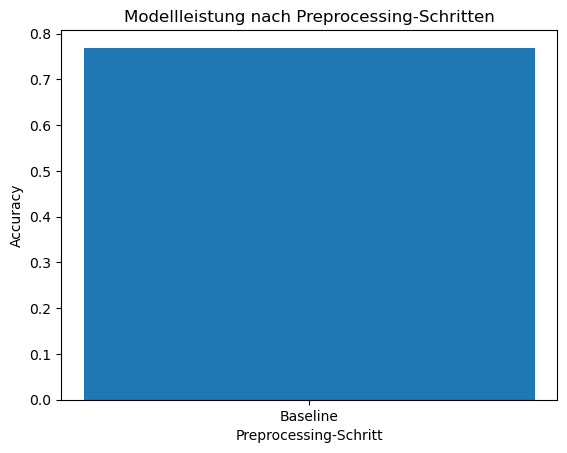

In [14]:
results = {
    'Baseline': accuracy_score(y_test, y_pred_baseline)
    #'Step 1': accuracy_score(y_test, y_pred_step1),
    # Füge weitere Schritte hinzu
}

# Balkendiagramm erstellen
plt.bar(results.keys(), results.values())
plt.xlabel('Preprocessing-Schritt')
plt.ylabel('Accuracy')
plt.title('Modellleistung nach Preprocessing-Schritten')
plt.show()

für das richtige modell muss ctry unknown funktion verändert werden, damit es Imputation gibt von town zu ctry siehe eda zelle 618

# Missing Values

## Data Quality

Der erste Preprocess Schritt ist das Erreichen der Datenqualität. Diese wird anhand folgender Funktionen erreicht:

In [15]:
def fix_unknownland(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt fehlende Länderwerte ('Ctry') basierend auf der Stadt ('Town').
    
    Falls 'Ctry' NaN ist, wird das Land anhand einer vordefinierten Zuordnung zur Stadt ermittelt.
    
    Args:
    df (pd.DataFrame): Eingabedaten mit den Spalten 'Ctry' (Land) und 'Town' (Stadt).
    
    Returns:
    pd.DataFrame: Daten mit aufgefüllten Länderinformationen.
    """
    town_to_country = {
        'Berlin': 'Germany',
        'London': 'UK',
        'Brisbane': 'Australia',
    }
    df['Ctry'] = df.apply(lambda row: town_to_country.get(row['Town'], row['Ctry']) if pd.isna(row['Ctry']) else row['Ctry'], axis=1)
    return df

def impute_town(df: pd.DataFrame) -> pd.DataFrame:
    """
    Füllt fehlende Städte ('Town') basierend auf dem bekannten Land ('Ctry') zufällig auf.
    
    Falls 'Town' NaN ist und 'Ctry' bekannt ist, wird eine Stadt aus einer vordefinierten Liste für das Land zufällig ausgewählt.
    
    Args:
    df (pd.DataFrame): Eingabedaten mit den Spalten 'Ctry' (Land) und 'Town' (Stadt).
    
    Returns:
    pd.DataFrame: Daten mit aufgefüllten Städten.
    """
    country_to_towns = {
        'Australia': ['Sydney', 'Melbourne', 'Brisbane'],
        'Germany': ['Berlin', 'Hamburg', 'Munich'],
        'UK': ['London', 'Birmingham', 'Manchester'],
        'USA': ['New York', 'Chicago', 'Los Angeles'],
        'India': ['Bangalore', 'Mumbai', 'Delhi'],
    }
    df['Town'] = df.apply(lambda row: np.random.choice(country_to_towns[row['Ctry']]) if pd.isna(row['Town']) and row['Ctry'] in country_to_towns else row['Town'], axis=1)
    return df

def calculate_biking_hours(df: pd.DataFrame) -> pd.DataFrame:
    """
    Berechnet fehlende Werte für 'Biking Hours per Week' basierend auf der Formel:
    Biking Hours per Week = Total Training Hours per Week - Swimming Hours per Week - Running Hours per Week.

    Args:
        df (pd.DataFrame): Der DataFrame, der die Spalten 'Total Training Hours per Week', 
                           'Swimming Hours per Week', 'Running Hours per Week' und 'Biking Hours per Week' enthält.

    Returns:
        pd.DataFrame: Der DataFrame mit berechneten Werten für 'Biking Hours per Week'.
    """
    df['Biking Hours per Week'] = df.apply(
        lambda row: row['Total Training Hours per Week'] - row['Swimming Hours per Week'] - row['Running Hours per Week']
        if pd.isna(row['Biking Hours per Week']) and not pd.isna(row['Total Training Hours per Week'])
        else row['Biking Hours per Week'],
        axis=1
    )
    return df

def calculate_total_training_hours(df: pd.DataFrame) -> pd.DataFrame:
    """
    Berechnet die Werte für 'Total Training Hours per Week' basierend auf:
    Total Training Hours per Week = Swimming Hours per Week + Biking Hours per Week + Running Hours per Week.

    Diese Berechnung erfolgt für **alle** Einträge, unabhängig davon, ob bereits ein Wert existiert. Dadurch werden Ausreiser eliminiert.

    Args:
        df (pd.DataFrame): DataFrame mit den Spalten 'Swimming Hours per Week', 
                           'Biking Hours per Week', 'Running Hours per Week' und 
                           'Total Training Hours per Week'.

    Returns:
        pd.DataFrame: Der DataFrame mit neu berechneten Werten für 'Total Training Hours per Week'.
    """
    df = df.copy()  # Vermeidet Änderungen am Original-DataFrame
    df['Total Training Hours per Week'] = (
        df['Swimming Hours per Week'].fillna(0) + 
        df['Biking Hours per Week'].fillna(0) + 
        df['Running Hours per Week'].fillna(0)
    )
    return df


def handle_vo2_max(df: pd.DataFrame) -> pd.DataFrame:
    """
    Setzt unplausible Werte (z. B. negative Werte) in der Spalte 'VO2 Max' auf NaN.

    Args:
        df (pd.DataFrame): Der DataFrame, der die Spalte 'VO2 Max' enthält.

    Returns:
        pd.DataFrame: Der DataFrame mit bereinigten Werten in 'VO2 Max'.
    """
    df['VO2 Max'] = df['VO2 Max'].apply(lambda x: x if 0 <= x <= 150 else np.nan)
    return df

def handle_age_of_customer(df: pd.DataFrame) -> pd.DataFrame:
    """
    Setzt unplausible Werte (z. B. negative Werte) in der Spalte 'Age of Customer' auf NaN.

    Args:
        df (pd.DataFrame): Der DataFrame, der die Spalte 'Age of Customer' enthält.

    Returns:
        pd.DataFrame: Der DataFrame mit bereinigten Werten in 'Age of Customer'.
    """
    df['Age of customer'] = df['Age of customer'].apply(lambda x: x if x > 0 else np.nan)
    return df

def drop_color_of_watch(df: pd.DataFrame) -> pd.DataFrame:
    """
    Löscht die Spalte 'Color of Watch' aus dem DataFrame, da sie keinen Zusammenhang mit dem Label oder anderen Daten hat.

    Args:
        df (pd.DataFrame): Der DataFrame, der die Spalte 'Color of Watch' enthält.

    Returns:
        pd.DataFrame: Der DataFrame ohne die Spalte 'Color of Watch'.
    """
    df = df.drop(columns=['Color of Watch'])
    return df

def drop_preferred_training_daytime(df: pd.DataFrame) -> pd.DataFrame:
    """
    Löscht die Spalte 'Preferred Training Daytime' aus dem DataFrame, da sie keinen Zusammenhang mit dem Label oder anderen Daten hat.

    Args:
        df (pd.DataFrame): Der DataFrame, der die Spalte 'Preferred Training Daytime' enthält.

    Returns:
        pd.DataFrame: Der DataFrame ohne die Spalte 'Preferred Training Daytime'.
    """
    df = df.drop(columns=['Preferred Training Daytime'])
    return df

def impute_training_daytime(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt fehlende Werte in 'Preferred Training Daytime' durch den häufigsten Wert (Modus).

    Args:
        df (pd.DataFrame): Der DataFrame mit der Spalte 'Preferred Training Daytime'.

    Returns:
        pd.DataFrame: DataFrame mit imputierten Werten.
    """
    df = df.copy()
    mode_value = df['Preferred Training Daytime'].mode()[0]  # Häufigster Wert
    df['Preferred Training Daytime'].fillna(mode_value, inplace=True)
    return df

def custom_transform_dq(df: pd.DataFrame) -> pd.DataFrame:
    """
    Führt eine Reihe von Datenbereinigungs- und Vorverarbeitungsschritten durch.

    Args:
        df (pd.DataFrame): Der ursprüngliche DataFrame.
        custom_transform_ctry_town -> Erbung vorheriger Imputation und Baseline

    Returns:
        pd.DataFrame: Der bereinigte und vorverarbeitete DataFrame.
    """
    df = custom_transform_baseline(df)

    df = fix_unknownland(df)
    df = impute_town(df)
    df = calculate_biking_hours(df)
    df = calculate_total_training_hours(df)
    df = handle_vo2_max(df)
    #df = handle_age_of_customer(df)
    df = drop_color_of_watch(df)
    #df = drop_preferred_training_daytime(df)
    df = impute_training_daytime(df)  
    return df

Funktionen bereinigen inkonsistente oder ungültige Werte:


1. `fix_unknownland()` – Füllt fehlende Länder (`Ctry`) basierend auf der Stadt (`Town`) auf.
2. `impute_town()` – Setzt fehlende Städte (`Town`) zufällig basierend auf dem Land (`Ctry`).
3. `calculate_biking_hours()` – Berechnet fehlende `Biking Hours per Week` aus den anderen Sportstunden.
4. `calculate_total_training_hours()` – Setzt `Total Training Hours per Week` auf die Summe der Einzelsportarten.
5. `handle_vo2_max()` – Ersetzt unplausible `VO2 Max`-Werte (z. B. negativ) durch `NaN`.
6. `handle_age_of_customer()` – Setzt negative `Age of customer`-Werte auf `NaN`.
7. `drop_color_of_watch()` – Entfernt die Spalte `Color of Watch`.
8. `drop_preferred_training_daytime()` – Entfernt die Spalte `Preferred Training Daytime`.

In [16]:
pipeline_dq = create_pipeline(custom_transform_dq)

# Trainiere das Modell
pipeline_dq.fit(X_train, y_train)

y_pred_dq = pipeline_dq.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_dq))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dq))
print("Classification Report:\n", classification_report(y_test, y_pred_dq))

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_97334/3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)
/Applications/anaconda3/envs/intro_ds_ai/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prep

Accuracy: 0.7435897435897436
Confusion Matrix:
 [[89 21]
 [29 56]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.81      0.78       110
         1.0       0.73      0.66      0.69        85

    accuracy                           0.74       195
   macro avg       0.74      0.73      0.74       195
weighted avg       0.74      0.74      0.74       195



/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_97334/3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)


In [76]:
X_train_transformed = pipeline_dq[:-2].transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed)

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_92282/3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)


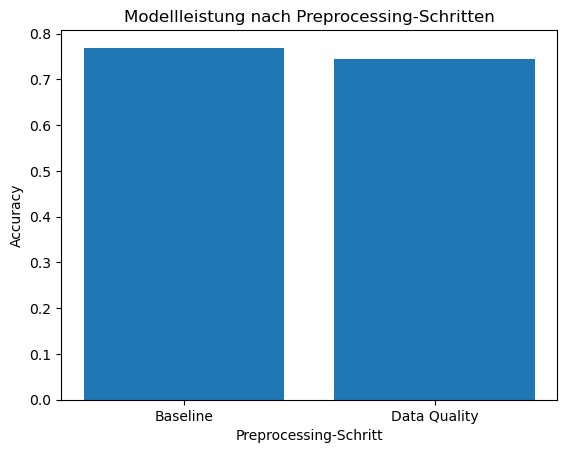

In [17]:
# Ergebnisse sammeln
results = {
    'Baseline': accuracy_score(y_test, y_pred_baseline),
    'Data Quality': accuracy_score(y_test, y_pred_dq)
    # Füge weitere Schritte hinzu
}

# Balkendiagramm erstellen
plt.bar(results.keys(), results.values())
plt.xlabel('Preprocessing-Schritt')
plt.ylabel('Accuracy')
plt.title('Modellleistung nach Preprocessing-Schritten')
plt.show()

Das neue Modell mit der Data Quality aus Eda, zeigt eine `Accuracy von 74,3 %`. Der `Recall (+1 %)`, die `Precision` bleiben stabil, und die `F1-Scores` hat sich minimal verschlechtert.

**Bis Dahin fertig**
**Trainingsdaten - Data Quality**
1. Löschen der 22 Zeilen, in denen das Label 0 ist.
2. Löschen der 7 Zeilen mit der doppelten ID.
3. Umbennung Germayn zu Germany in Spalte `Ctry` 
4. Anpassung UnknownLand in Spalte `Ctry`
5. Berechnung der fehlenden Werte für `Biking Hours per Week` durch `Total Training Hours per Week` - `Swimming Hours per Week` -  `Running Hours per Week` (Aureißer bei der Gesamttrainingszeit betreffen hier nicht die fehlenden Wert für Biking Hours) (*Rule based Imputation*)
6. Unplausible und fehlende Werte für `Total Training Hours per Week` durch andere Spalten berechnen lassen und ersetzen. (*Rule based Imputation*)
7. Setzen der unplausiblen Werte von `VO2 Max` und `Age of Customer` auf NaN.  
8. Löschung Feature `Color of Watch`, `Prefered Training Datetime` aufgrund fehlendem Zusammenhang mit Label und anderen Daten
Zu 8. `Prefered Training Datetime` erhöht die accuracy um zwei Prozente bereits im baseline Model

## Imputation

**Trainingsdaten - Imputation**  
1. 1 Fehlender Wert in `Days since Update` befüllen mit dem Mittelwert je Label, aufgrund fehlendem Zusammenhang mit anderen Daten
2. 1 Fehlender Wert in `Subscription Type` mit Hilfe Informationen `10k Running Time Prediction` befüllen (*Regression Imputation*)
3. 10 falsche Werte in `Age of Customer`  mit Hilfe folgender Spalten befüllen: `10k Running Time Prediction`, `Ctry`, `Support Cases of Customer`, `Customer Years` (*Regression Imputation*)
4. 19 Fehlende Werte in `Calories Burned per Week` mit Hilfe folgender Spalten befüllen: `Sex`, `Biking Hours per Week`, `Total Training Hours per Week`, `Swimming Hours per Week`, `Running Hours per Week` (Hauptsache Fahrradzeiten, andere Zeiten eher weniger relevant) (*Regression Imputation*)
5. 28 Fehlende Werte in `Goal of Training` mit Hilfe folgender Spalten befüllen: `Swimming Hours per Week`, `Biking Hours per Week`, `Running Hours per Week`, `Total Training Hours per Week`, `10k Running Time Prediction`, `Calories Burned per Week` (*Regression Imputation*)
6. 10 Fehlende Werte in `VO2 Max` mit Hilfe folgender Spalten befüllen: `Goal of Training`, `10k Running Time Prediction`, `Calories Burned per Week`, `Age of customer`
7. 27 Fehlende Werte in `Synchronisation` mit Hilfe folgender Spalten befüllen: `VO2 Max` (*Regression Imputation*) **habe ich nicht geschafft**
8. 39 Fehlende Werte in Town in einer Kombination aus *Regression Imputation* und *Rule based Imputation*: Erst einschränken, welche Auswahl an Städten möglich ist anhand von `Ctry`. Dann anhand folgender Werte bestimmen, welches aus den möglichen Städten die wahrscheinlichste ist: `Age of customer`, `Swimming Hours per Week`, `Biking Hours per Week`, `10k Running Time Prediction`, `Calories Burned per Week` 

In [18]:
def impute_subscription_type(df: pd.DataFrame) -> pd.DataFrame:
    """
    Füllt fehlende Werte in der Spalte 'Subscription Type' mithilfe einer Regression basierend auf '10k Running Time Prediction'.
    
    Args:
        df (pd.DataFrame): Der Eingabe-DataFrame mit den Spalten 'Subscription Type' (Kategorie) und 
                           '10k Running Time Prediction' (numerisch).

    Returns:
        pd.DataFrame: Der DataFrame mit imputierten Werten für 'Subscription Type'.
    """
    df_copy = df.copy()  # Kopie des DataFrames, um Originaldaten nicht zu verändern
    
    # Prüfen, ob überhaupt fehlende Werte in "Subscription Type" existieren
    if df_copy['Subscription Type'].isna().sum() == 0:
        return df_copy  # Falls keine fehlenden Werte, gib unveränderten DataFrame zurück
    
    # Label-Encoding für "Subscription Type"
    le = LabelEncoder()
    df_copy.dropna(subset=['Subscription Type'], inplace=True)  # Fehlende Werte vor Encoding entfernen
    df_copy['Subscription Type Encoded'] = le.fit_transform(df_copy['Subscription Type'])
    
    # Trainingsdaten (Zeilen ohne fehlende Werte)
    train_df = df_copy.dropna(subset=['Subscription Type Encoded'])

    # Regressionsmodell erstellen & trainieren
    reg = LinearRegression()
    reg.fit(train_df[['10k Running Time Prediction']], train_df['Subscription Type Encoded'])

    # Zeilen mit fehlendem "Subscription Type"
    missing_rows = df[df['Subscription Type'].isna()]

    if not missing_rows.empty:
        # Vorhersage für fehlende Werte
        predicted_values = reg.predict(missing_rows[['10k Running Time Prediction']])
        predicted_labels = le.inverse_transform([int(round(val)) for val in predicted_values])  # In Kategorie umwandeln

        # Fehlenden Wert im Original-DataFrame ersetzen
        df.loc[df['Subscription Type'].isna(), 'Subscription Type'] = predicted_labels

    return df  # DataFrame mit imputierten Werten zurückgeben


def impute_negative_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt Werte von -1 in 'Age of customer' mithilfe einer linearen Regression.

    Args:
        df (pd.DataFrame): Eingabe-DataFrame.

    Returns:
        pd.DataFrame: DataFrame mit imputierten Werten für 'Age of customer'.
    """
    df = df.copy()  # Kopie erstellen, um inplace-Änderungen zu vermeiden
    
    model = LinearRegression()

    # Feature-Spalten für das Modell
    feature_cols = ['10k Running Time Prediction', 'Support Cases of Customer', 'Customer Years']

    # Zeilen für Training auswählen (wo 'Age of customer' bekannt ist)
    train_data = df[df['Age of customer'].notna() & (df['Age of customer'] != -1)].copy()

    # Sicherstellen, dass Feature-Spalten keine fehlenden Werte enthalten
    train_data = train_data.dropna(subset=feature_cols)

    X_train = train_data[feature_cols]
    y_train = train_data['Age of customer']

    # Prüfen, ob genug Daten für das Training vorhanden sind
    if len(y_train) > 5:  # Mindestens 5 Datenpunkte für ein stabiles Modell
        model.fit(X_train, y_train)

        # Zeilen mit fehlendem oder ungültigem Alter (-1) auswählen
        missing_data_mask = df['Age of customer'] == -1

        # Prüfen, ob es Zeilen zum Imputieren gibt
        if missing_data_mask.any():
            X_test = df.loc[missing_data_mask, feature_cols].dropna()

            if not X_test.empty:  # Sicherstellen, dass X_test nicht leer ist
                df.loc[X_test.index, 'Age of customer'] = model.predict(X_test)

    # Falls nach der Imputation noch NaN-Werte vorhanden sind, ersetze sie mit dem Median
    df['Age of customer'] = df['Age of customer'].fillna(df['Age of customer'].median())

    return df

def impute_calories_burned(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt fehlende Werte in 'Calories Burned per Week' durch Regression Imputation.
    Nutzt: 'Sex', 'Biking Hours per Week', 'Total Training Hours per Week',
           'Swimming Hours per Week', 'Running Hours per Week'.

     Args:
        df (pd.DataFrame): Der Eingabe-DataFrame mit den Spalten 'Calories Burned per Week' .

    Returns:
        pd.DataFrame: Der DataFrame mit imputierten Werten für 'Calories Burned per Week'.
    """
    df = df.copy()  # Verhindert inplace-Änderungen

    # Label-Encoding für 'Sex', aber nur eine Kopie erstellen
    label_encoder = LabelEncoder()
    df['Sex Encoded'] = label_encoder.fit_transform(df['Sex'].astype(str))  # Sicherstellen, dass es Strings sind

    # Feature-Spalten für das Modell
    feature_cols = ['Sex Encoded', 'Biking Hours per Week', 'Total Training Hours per Week', 
                    'Swimming Hours per Week', 'Running Hours per Week']

    # Trainingsdaten: Nur Zeilen ohne NaN in "Calories Burned per Week" & ohne fehlende Feature-Werte
    train_data = df.dropna(subset=['Calories Burned per Week'] + feature_cols)

    X_train = train_data[feature_cols]
    y_train = train_data['Calories Burned per Week']

    # Lineares Modell trainieren
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Zeilen mit fehlenden "Calories Burned per Week" Werten
    missing_mask = df['Calories Burned per Week'].isna()
    
    if missing_mask.any():
        X_test = df.loc[missing_mask, feature_cols]

        # Entferne Zeilen mit fehlenden Werten, um den Fehler zu vermeiden
        X_test_clean = X_test.dropna()

        if not X_test_clean.empty:  # Falls nach dem Drop noch Zeilen übrig sind
            predicted_values = model.predict(X_test_clean)

            # Setze nur die vorhersagbaren Werte zurück
            df.loc[X_test_clean.index, 'Calories Burned per Week'] = predicted_values

    # Entferne die temporäre Spalte 'Sex Encoded'
    df = df.drop(columns=['Sex Encoded'])

    return df

def impute_goal_of_training(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt fehlende Werte in 'Goal of Training' mithilfe einer logistischen Regression (für kategoriale Werte).
    Nutzt als Prädiktoren:
    - 'Swimming Hours per Week'
    - 'Biking Hours per Week'
    - 'Running Hours per Week'
    - 'Total Training Hours per Week'
    - '10k Running Time Prediction'
    - 'Calories Burned per Week'
    
    
     Args:
        df (pd.DataFrame): Der Eingabe-DataFrame mit den Spalten ''Goal of Training' .

    Returns:
        pd.DataFrame: Der DataFrame mit imputierten Werten für ''Goal of Training'.
    """
    df = df.copy()  # Verhindert inplace-Änderungen

    # Label-Encoding für 'Goal of Training' (da kategoriale Variable)
    label_encoder = LabelEncoder()

    # Falls ALLE Werte in 'Goal of Training' fehlen -> Abbruch
    if df['Goal of Training'].isna().all():
        print("⚠ Alle Werte in 'Goal of Training' fehlen – Imputation nicht möglich.")
        return df

    df['Goal of Training Encoded'] = label_encoder.fit_transform(df['Goal of Training'].astype(str))

    # Features für die Regression
    feature_cols = ['Swimming Hours per Week', 'Biking Hours per Week', 'Running Hours per Week',
                    'Total Training Hours per Week', '10k Running Time Prediction', 'Calories Burned per Week']

    # Entferne Zeilen mit NaNs in Feature-Spalten (aber nicht in 'Goal of Training')
    df_clean = df.dropna(subset=feature_cols)

    # Trainingsdaten ohne NaN in 'Goal of Training'
    train_data = df_clean.dropna(subset=['Goal of Training'])

    X_train = train_data[feature_cols]
    y_train = train_data['Goal of Training Encoded']

    # Modell trainieren
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Zeilen mit fehlenden 'Goal of Training' Werten
    missing_mask = df['Goal of Training'].isna()

    if missing_mask.any():
        X_test = df.loc[missing_mask, feature_cols]

        # Entferne Zeilen mit NaN in den Prädiktor-Spalten (sonst Fehler in model.predict)
        X_test_clean = X_test.dropna()

        if not X_test_clean.empty:  # Falls noch Zeilen übrig sind
            predicted_values = model.predict(X_test_clean)

            # Rücktransformation der Werte in die ursprünglichen Kategorien
            df.loc[X_test_clean.index, 'Goal of Training'] = label_encoder.inverse_transform(predicted_values)

    # Entferne die temporäre Spalte
    df.drop(columns=['Goal of Training Encoded'], inplace=True)

    return df

def impute_vo2_max(df: pd.DataFrame) -> pd.DataFrame:
    """
    Füllt fehlende Werte in 'VO2 Max' mit Regression Imputation.
    
    Verwendet die Spalten:
    - 'Goal of Training' (kategorial, wird mit LabelEncoder kodiert)
    - '10k Running Time Prediction'
    - 'Calories Burned per Week'
    - 'Age of customer'
    
    Args:
        df (pd.DataFrame): Eingabedaten mit fehlenden Werten in 'VO2 Max'.
    
    Returns:
        pd.DataFrame: DataFrame mit imputierten Werten für 'VO2 Max'.
    """
    df = df.copy()  # Verhindert inplace-Änderungen

    # Kategoriale Variable "Goal of Training" in numerische Werte umwandeln
    le = LabelEncoder()
    if df['Goal of Training'].isna().sum() == 0:  # Prüfen, ob fehlende Werte in der Kategorie sind
        df['Goal of Training Encoded'] = le.fit_transform(df['Goal of Training'])
    else:
        df = df.dropna(subset=['Goal of Training'])  # Falls fehlend, Zeilen entfernen
        df['Goal of Training Encoded'] = le.fit_transform(df['Goal of Training'])

    # Regressions-Imputation mit IterativeImputer
    imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=42)
    features = ['Goal of Training Encoded', '10k Running Time Prediction', 'Calories Burned per Week', 'Age of customer']

    df['VO2 Max'] = imputer.fit_transform(df[['VO2 Max'] + features])[:, 0]  # Erste Spalte sind die imputierten Werte

    # Entferne die temporäre kodierte Spalte
    df.drop(columns=['Goal of Training Encoded'], inplace=True)

    return df

def impute_synchronisation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputiert fehlende Werte in der Spalte 'Synchronisation' basierend auf 'VO2 Max'
    mit einer logistischen Regression.

    Args:
        df (pd.DataFrame): Der Eingabe-DataFrame mit fehlenden Werten in 'Synchronisation'.

    Returns:
        pd.DataFrame: DataFrame mit imputierten Werten für 'Synchronisation'.
    """
    df = df.copy()  # Verhindert inplace-Änderungen

    # Falls "nan" als String gespeichert ist, konvertiere es zu einem echten NaN-Wert
    df['Synchronisation'] = df['Synchronisation'].replace('nan', np.nan)

    # Entferne Zeilen mit fehlendem 'VO2 Max', da es die Prädiktorvariable ist
    df = df.dropna(subset=['VO2 Max'])

    # Konvertiere 'Synchronisation' in eine binäre numerische Variable: 'Yes' → 1, 'No' → 0
    df['Synchronisation'] = df['Synchronisation'].replace({'Yes': 1, 'No': 0})

    # Trainingsdaten: Nur Zeilen, wo 'Synchronisation' bekannt ist
    train_data = df[df['Synchronisation'].notna()]

    # Testdaten: Zeilen, wo 'Synchronisation' fehlt (NaN)
    test_data = df[df['Synchronisation'].isna()]

    # Features und Labels für das Training
    X_train = train_data[['VO2 Max']]
    y_train = train_data['Synchronisation']

    # Prüfen, ob genug Daten zum Trainieren vorhanden sind
    if len(y_train) > 5:
        model = LogisticRegression()
        model.fit(X_train, y_train)  # Trainiere das Modell

        # Nur Vorhersagen für Zeilen mit fehlender Synchronisation
        if not test_data.empty:
            X_test = test_data[['VO2 Max']]
            y_pred = model.predict(X_test)

            # Setze vorhergesagte Werte zurück in den DataFrame
            df.loc[test_data.index, 'Synchronisation'] = y_pred

    # Konvertiere zurück in 'Yes' und 'No'
    df['Synchronisation'] = df['Synchronisation'].replace({1: 'Yes', 0: 'No'})

    return df


def all_imputation(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    
    #df = custom_transform_baseline(df)
    df = custom_transform_dq(df)

    df = impute_subscription_type(df)
    df = impute_negative_age(df)
    df = impute_calories_burned(df)
    df = impute_goal_of_training(df)
    df = impute_vo2_max(df)
    df = impute_synchronisation(df)
    return df

In [80]:
df_training[df_training["Age of customer"]==-1]

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Color of Watch,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,,
C0212,-1.0,Male,USA,Chicago,2.78,1.16,2.94,6.89,52.24,40.09,3199.91,0.0,4.0,Recreation,Morning,Basic,Black,No,1.0,117.0
C0217,-1.0,Female,India,NaN,2.31,NaN,4.43,13.33,40.33,52.93,6736.52,0.0,6.0,Fitness,Evening,Free,Black,Yes,0.0,271.0
C0480,-1.0,Other,Australia,Melbourne,5.20,0.00,1.63,6.83,30.08,60.34,3151.63,2.0,5.0,Fitness,Morning,Premium,White,Yes,0.0,207.0
C0661,-1.0,Other,Germany,Hamburg,1.66,3.49,2.41,7.57,52.23,41.03,3796.06,4.0,1.0,Recreation,Morning,Free,Black,Yes,0.0,214.0
C0697,-1.0,Other,USA,New York,2.79,4.73,0.40,7.92,47.31,50.81,4045.48,1.0,2.0,Fitness,Evening,Premium,White,Yes,0.0,442.0
C0711,-1.0,Female,Germany,Berlin,3.09,4.62,3.29,10.99,48.52,43.20,5499.17,4.0,2.0,Fitness,Morning,Premium,Black,Yes,1.0,178.0
C0808,-1.0,Female,Germany,Berlin,1.74,1.49,0.88,4.11,39.28,48.41,1768.41,0.0,7.0,Recreation,NaN,Premium,Black,Yes,0.0,165.0
C0851,-1.0,Female,India,Mumbai,0.00,2.57,2.54,5.11,39.98,51.19,2831.74,1.0,5.0,Recreation,Morning,Free,Black,Yes,0.0,317.0
C0889,-1.0,Male,Australia,Brisbane,1.90,9.88,5.01,16.79,66.41,37.59,8561.68,1.0,3.0,Competition,Evening,Premium,White,Yes,1.0,371.0


In [19]:
pipeline_imp = create_pipeline(all_imputation)

# Trainiere das Modell
pipeline_imp.fit(X_train, y_train)

y_pred_imp = pipeline_imp.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_imp))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_imp))
print("Classification Report:\n", classification_report(y_test, y_pred_imp))

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_97334/3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)
/Applications/anaconda3/envs/intro_ds_ai/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prep

Accuracy: 0.7487179487179487
Confusion Matrix:
 [[89 21]
 [28 57]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.81      0.78       110
         1.0       0.73      0.67      0.70        85

    accuracy                           0.75       195
   macro avg       0.75      0.74      0.74       195
weighted avg       0.75      0.75      0.75       195



/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_97334/3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)
/Applications/anaconda3/envs/intro_ds_ai/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prep

1. `impute_subscription_type()` – Füllt fehlende Werte in der Spalte `Subscription Type` mithilfe einer Regression basierend auf `10k Running Time Prediction`.
2. `impute_negative_age()` – Ersetzt -1-Werte in der `Age of Customer`-Spalte durch eine lineare Regression, die auf anderen numerischen Features basiert.
3. `impute_calories_burned()` – Ersetzt fehlende Werte in der Spalte `Calories Burned per Week` durch Regression unter Verwendung mehrerer Trainingsmerkmale.
4. `impute_goal_of_training()` – Imputiert fehlende Werte in der Spalte `Goal of Training` mit einer logistischen Regression, die auf verschiedenen Trainingsdaten basiert.
5. `impute_vo2_max()` – Füllt fehlende Werte in der `VO2 Max`-Spalte durch Regression, unter Verwendung von Features wie `Goal of Training`, `10k Running Time Prediction`, `Calories Burned per Week` und `Age of Customer`.
6. `impute_synchronisation()` - Ersetzt nan String Werte, mit neuen Werte durch `VO2 Max` Imputation 

Das Modell hat eine `Accuracy` von `74.8%`, was darauf hinweist, dass es in der Lage ist, viele der Beispiele korrekt zu klassifizieren. Der Recall für Klasse 0 (negativ) ist relativ hoch (84%), was darauf hinweist, dass das Modell in den meisten Fällen korrekt vorhersagt, wenn ein Beispiel tatsächlich negativ ist. Jedoch ist der Recall für Klasse 1 (positiv) mit 66% etwas niedriger, was darauf hindeutet, dass das Modell Schwierigkeiten hat, alle positiven Beispiele zu erkennen.

Trotzdem ist der F1-Score für beide Klassen relativ gut, insbesondere für Klasse 0 mit einem F1-Score von 0.79. Insgesamt zeigt das Modell eine starke Leistung in Bezug auf die Negativklassifikation, hat jedoch etwas mehr Schwierigkeiten, alle positiven Fälle zu erfassen.


Man erkennt aber keine erheblichen Verbesserung durch das Missing Values Process.

In [20]:
df_training_no_missing_values = all_imputation(df_training)
df_training_no_missing_values

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_97334/3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)
/Applications/anaconda3/envs/intro_ds_ai/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prep

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,
C0001,61.0,Other,UK,Birmingham,2.52,0.10,1.78,4.40,23.08,60.72,2329.950000,2.0,1.0,Fitness,Evening,Free,Yes,1.0,198.0
C0003,57.0,Other,Australia,Sydney,1.55,10.01,4.57,16.13,39.04,54.37,7904.930000,2.0,1.0,Fitness,Evening,Premium,Yes,0.0,270.0
C0004,30.0,Other,India,Bangalore,1.19,12.04,8.64,21.87,71.59,33.92,10839.810000,2.0,0.0,Competition,Afternoon,Free,Yes,1.0,173.0
C0005,21.0,Male,Germany,Munich,2.25,4.67,0.92,7.84,49.09,44.97,3958.160897,3.0,0.0,Recreation,Evening,Premium,No,1.0,178.0
C0006,63.0,Male,India,Mumbai,0.80,5.88,0.67,7.35,13.91,62.46,3575.960000,3.0,3.0,Recreation,Morning,Basic,Yes,0.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0996,28.0,Female,Australia,Brisbane,2.38,0.28,2.79,5.45,61.05,40.38,2589.770000,0.0,3.0,Recreation,Morning,Premium,Yes,0.0,393.0
C0997,54.0,Female,Australia,Melbourne,1.80,4.45,1.35,7.60,34.50,56.38,4104.150000,0.0,3.0,Recreation,Afternoon,Free,Yes,0.0,88.0
C0998,35.0,Other,USA,New York,3.91,0.57,5.57,10.05,58.63,37.27,5078.450000,4.0,6.0,Fitness,Afternoon,Premium,Yes,1.0,162.0


In [21]:
df_training_no_missing_values.isnull().sum()

Age of customer                  0
Sex                              0
Ctry                             0
Town                             0
Swimming Hours per Week          0
Biking Hours per Week            0
Running Hours per Week           0
Total Training Hours per Week    0
VO2 Max                          0
10k Running Time Prediction      0
Calories Burned per Week         0
Support Cases of Customer        0
Customer Years                   0
Goal of Training                 0
Preferred Training Daytime       0
Subscription Type                0
Synchronisation                  0
User of latest model             0
Days since Update                0
dtype: int64

In [22]:
df_training_no_missing_values["Synchronisation"].unique()

array(['Yes', 'No'], dtype=object)

In [23]:
df_training_no_missing_values[df_training_no_missing_values["Age of customer"].isnull()]

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,


In [24]:
df_training_no_missing_values[df_training_no_missing_values["VO2 Max"]>200]

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,


In [25]:
df_training_no_missing_values[df_training_no_missing_values["Total Training Hours per Week"]>90]

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,


Ich habe die Daten verbessert. Die Ausreißer sind draußen und wurden imputiert.

In [26]:
df_training_no_missing_values.to_parquet("../data/processed/df_training_no_missing_values.parquet", index=True)

# Outlier

In [251]:
def remove_outliers(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Entfernt Ausreißer aus den angegebenen Spalten des DataFrames.
    
    Args:
    df (pd.DataFrame): Eingabedaten.
    columns (list): Liste der Spalten, in denen Ausreißer entfernt werden sollen.
    
    Return:
    pd.DataFrame: DataFrame ohne Ausreißer in den angegebenen Spalten.
    """
    df_no_outliers = X.copy()
    for column in columns:
        Q1 = df_no_outliers[column].quantile(0.25)
        Q3 = df_no_outliers[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]
    
    # Stelle sicher, dass die Zeilen aus X und y übereinstimmen
    y_no_outliers = y[df_no_outliers.index]
    
    return df_no_outliers, y_no_outliers

columns_to_check = ['Age of customer', 'Swimming Hours per Week', 'Biking Hours per Week', 'Running Hours per Week', 
                    'Total Training Hours per Week', 'VO2 Max', '10k Running Time Prediction', 'Calories Burned per Week', 'Support Cases of Customer',
                    "Customer Years"]
